# Do I want this undulator?

This notebooks shows how to estimate the applicability of a set of undulator params (length, period length, K, etc) to your beamline needs.
* First we compute undulator fundamental frequencies analytically and using XRT for a selected deflection value K.
* Then we compute the full undulator intensity spectrum for a deflection parameter range
* And at last we select optimal harmonic and K for a set of photon energies we intend to use, and calculate source size and divergence for each one.

## Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.utils import io

import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.figure_factory as ff
pio.renderers.default = 'svg'
# pio.renderers.default = 'iframe'

from scipy.spatial import Delaunay
import matplotlib
from matplotlib import pyplot as plt

import xrt.backends.raycing.sources as rs
import params.sources as ps
from scipy.signal import find_peaks
from scipy.interpolate import griddata
from scipy.interpolate import UnivariateSpline

import adaptive
adaptive.notebook_extension()

## Computing undulator spectrum
Here we compare the fundamental frequencies computation formula with XRT undulator modelling code

Formulas from Willmott:
$$
n \lambda _n [\mathrm{AA}]= \frac{13.056 \cdot \lambda _u [\mathrm{cm}]}{\mathcal{E} ^2 [\mathrm{GeV}]} \cdot \left(  1 + \frac{K^2}{2}\right)
$$
$$
E [\textrm{eV}] = \frac{12398}{\lambda [\textrm{AA}]}
$$

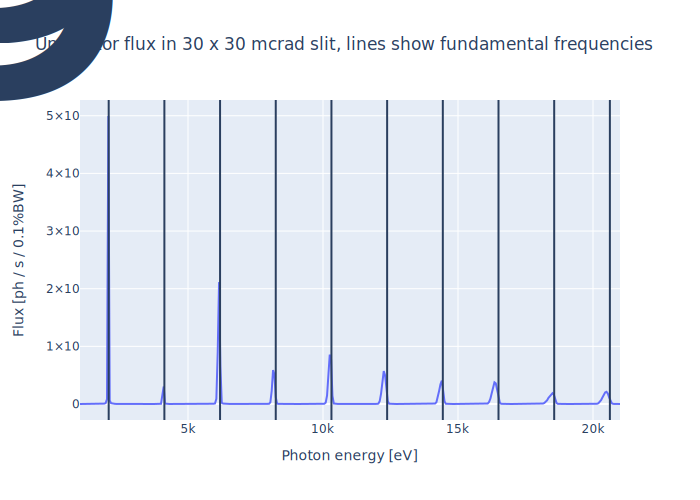

In [3]:
# setting up computation mesh:
# Intensities will be computed over a 3D mesh grid of 
# energies, theta, and psi 
energy = np.linspace(1.0e3, 21.0e3, 401)
theta = np.linspace(-1, 1, 51) * 30e-6
psi = np.linspace(-1, 1, 51) * 30e-6

# setting up undulator params
# computational limits, 
# storage ring params (energy, current, etc),
# insertion device params (deflection K, period, length, etc)
und_kwargs = dict(
    xPrimeMax=theta[-1] * 1e3,
    zPrimeMax=psi[-1] * 1e3,
    **ps.ring_kwargs,
    **ps.undulator_1_1_kwargs,
    targetOpenCL="CPU",
    distE="BW",
)

# computing intensities on 3D mesh grid
# there is a lot of text printed by xrt when creating Undulator object, hence the with ... statement
with io.capture_output() as captured:
    source = rs.Undulator(**und_kwargs)
    I0, l1, l2, l3 = source.intensities_on_mesh(energy, theta, psi)

# integrating over angles to get total flux 
dtheta, dpsi = theta[1] - theta[0], psi[1] - psi[0]
flux = I0.sum(axis=(1, 2)) * dtheta * dpsi

# plotting
fig = go.Figure()
fig.add_trace(go.Line(x=energy, y=flux, name="XRT"))
for n in range(1, 11):
    fig.add_vline(x=n * 123980. / (13.056 * ps.undulator_1_1_kwargs['period'] * (1 + 0.5 * ps.undulator_1_1_kwargs['K']**2) / ps.ring_kwargs['eE']**2))
fig.update_layout(
    title=dict(text=f"Undulator flux in 30 x 30 mcrad slit, lines show fundamental frequencies"),
    xaxis=dict(title=dict(text="Photon energy [eV]")),
    yaxis=dict(title=dict(text="Flux [ph / s / 0.1%BW]"))
)
fig.show()


## Computing undulator $I(h\nu, K)$ plot using Adaptive + XRT
Here we use [adaptive](https://adaptive.readthedocs.io/en/latest/) library to compute the undulator spectrum vs deflection parameter K dependence. Adaptive intelligently selects points in ($h\nu$, K) space to reduce computation time and make a pretty graph.

### This cell defines the computation, setting up `adaptive.Learner2D` object

In [ ]:
energy = np.linspace(1.0e3, 21.0e3, 4001)
theta = np.linspace(-1, 1, 51) * 30e-6
psi = np.linspace(-1, 1, 51) * 30e-6
dtheta, dpsi = theta[1] - theta[0], psi[1] - psi[0]

und_kwargs = dict(
    xPrimeMax=theta[-1] * 1e3,
    zPrimeMax=psi[-1] * 1e3,
    **ps.ring_kwargs,
    **ps.undulator_1_1_kwargs,
    targetOpenCL="CPU",
    distE="BW",
)

with io.capture_output() as captured:
    source = rs.Undulator(**und_kwargs)

# it is better to learn on the log(I) compared to I, 
# the I distribution is too sharp for the learning algorithm
def log_intensity(arg):
    k, en = arg
    source.K = k
    with io.capture_output() as captured:
        I0, l1, l2, l3 = source.intensities_on_mesh([en], theta, psi)
    return np.log((I0.sum(axis=(1, 2)) * dtheta * dpsi)[0])

ln = adaptive.Learner2D(log_intensity, bounds=[(0.5, 1.8), (1e3, 20e3)])

### This cell starts and monitors the computation (it runs in the background and does not hold the cell)

In [ ]:
runner = adaptive.Runner(ln, loss_goal=0.001)
runner.live_info()
runner.live_plot()

### Run this cell to stop the computation (results will be available from `Learner2D` object)

In [ ]:
runner.cancel()

### Save the results to file

In [ ]:
df = ln.to_dataframe(x_name="K", y_name="E", z_name="logI")
df["I"] = np.exp(df["logI"])

# save and reload data from file
df.to_csv("Undulator_1_1_flux.csv")

### Load and plot the results

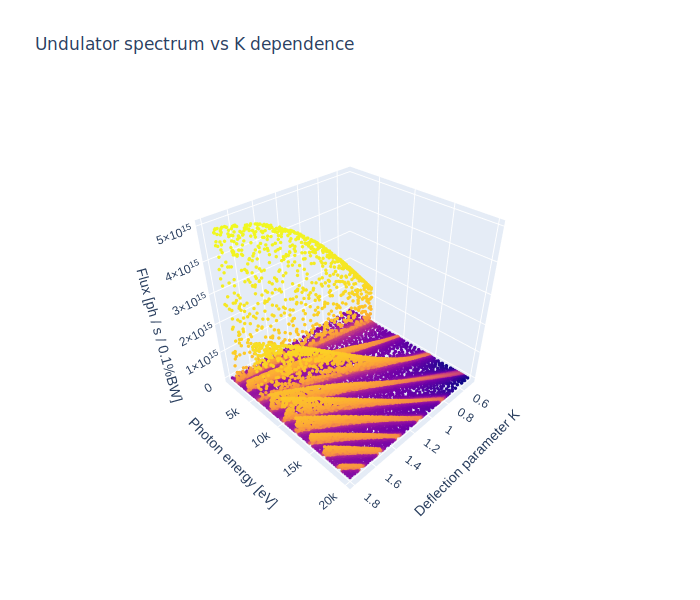

In [4]:
# load data from file
df = pd.read_csv("Undulator_1_1_flux.csv")

# sort the data
raw_data = df[["K", "E", "I"]].to_numpy()
ii = np.lexsort((raw_data[:, 0], raw_data[:, 1]))
raw_data = raw_data[ii]



# plot
fig = go.Figure()


fig.add_trace(go.Scatter3d(
    x=df['K'], y=df['E'], z=df['I'], 
    mode='markers', marker=dict(color=df['logI'],size=2)))

fig.update_layout(
    title=dict(text=f"Undulator spectrum vs K dependence"),
    scene_camera = dict(
        up=dict(x=0, y=0, z=1),
        center=dict(x=0, y=0, z=0),
        eye=dict(x=1.5, y=1.5, z=1.5)
    ),
height=600)
fig.update_scenes(xaxis_title_text='Deflection parameter K',  
                  yaxis_title_text='Photon energy [eV]',  
                  zaxis_title_text='Flux [ph / s / 0.1%BW]')

fig.show()

## Computing undulator photon source size

### Using the previous plot we determined the best K and harmonic for each photon energy

In [5]:
und_configurations = [
    {"E": 8800, "K": 1.309, "harmonic": 3},  # in spectra 8850 & dx'=dz'=0.015 mrad
    {"E": 15000, "K": 1.76, "harmonic":7},   # in spectra 15100 & dx'=dz'=0.010 mrad
    {"E": 17000, "K": 1.58, "harmonic":7},
]

### For selected configurations we compute point light source approximation parameters
* Harmonic photon energy FWHM
* Source size $dx$, $dz$
* Source divergence $dx^{\prime}$, $dz^{\prime}$

/nix/store/i63lpv0lgmz4gmar81x5rxksyc2nm66f-python3.12-plotly-5.24.1/lib/python3.12/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




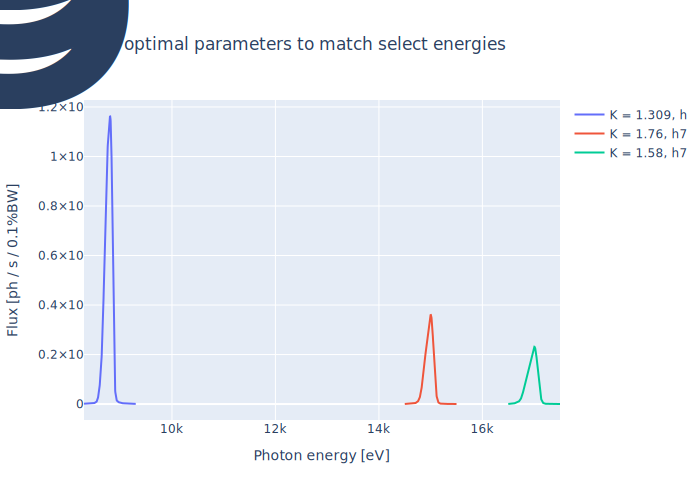

           K  harmonic      E FWHM        dx        dz       dx'       dz'
E                                                                         
8800   1.309         3  162.247860  0.038931  0.006036  0.000007  0.000007
15000  1.760         7  176.396078  0.038888  0.005750  0.000010  0.000010
17000  1.580         7  218.511848  0.038871  0.005635  0.000010  0.000009


In [7]:
fig = go.Figure()

theta = np.linspace(-1, 1, 51) * 30e-6
psi = np.linspace(-1, 1, 51) * 30e-6

source_params = und_configurations.copy()
for ii in range(len(source_params)):
    uconf = source_params[ii]
    ukwgs = ps.undulator_1_1_kwargs.copy()
    ukwgs["K"] = uconf["K"]
    energy = np.linspace(uconf["E"] - 500, uconf["E"] + 500, 401)

    und_kwargs = dict(
        xPrimeMax=theta[-1] * 1e3,
        zPrimeMax=psi[-1] * 1e3,
        **ps.ring_kwargs,
        **ukwgs,
        targetOpenCL="CPU",
        distE="BW",
    )
    with io.capture_output() as captured:
        source = rs.Undulator(**und_kwargs)
        xs, zs = source.get_SIGMA(uconf["E"])
        xps, zps = source.get_SIGMAP(uconf["E"])
        I0, l1, l2, l3 = source.intensities_on_mesh(energy, theta, psi)

    dtheta, dpsi = theta[1] - theta[0], psi[1] - psi[0]
    flux = I0.sum(axis=(1, 2)) * dtheta * dpsi

    spline = UnivariateSpline(energy, flux - np.max(flux)/2., s=0)
    r1, r2 = spline.roots()
    source_params[ii]["E FWHM"] = r2 - r1
    source_params[ii]["dx"] = xs
    source_params[ii]["dz"] = zs
    source_params[ii]["dx'"] = xps
    source_params[ii]["dz'"] = zps

    fig.add_trace(go.Line(x=energy, y=flux, name=f"K = {uconf["K"]}, h{uconf["harmonic"]}"))
fig.update_layout(
    title=dict(text=f"Undulator optimal parameters to match select energies"),
    xaxis=dict(title=dict(text="Photon energy [eV]")),
    yaxis=dict(title=dict(text="Flux [ph / s / 0.1%BW]"))
)
fig.show()

source_params = pd.DataFrame(source_params)
source_params = source_params.set_index("E")
source_params.to_csv("Undulator_1_1_params.csv")
print(source_params)